### Création session Spark

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Movie Recommendation System") \
    .config("spark.driver.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "8") \
    .getOrCreate()

### Chargement des données

In [3]:
ratings = spark.read.csv("ratings.csv", header=True, inferSchema=True)
movies = spark.read.csv("movies.csv", header=True, inferSchema=True)

In [4]:
from pyspark.sql.functions import col

df = ratings.select(
    col("userId").cast("int"),
    col("movieId").cast("int"),
    col("rating").cast("float"),
    col("timestamp").cast("long")
)

df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: float (nullable = true)
 |-- timestamp: long (nullable = true)



### Segmentation des données

In [5]:
from pyspark.sql import Window
from pyspark.sql.functions import row_number, count, when

# Paramètres de split
TRAIN_FRAC = 0.6
VAL_FRAC = 0.2
MIN_USER_RATINGS = 5
MIN_ITEM_RATINGS = 5

# 1. Filtrer utilisateurs/films trop peu actifs
user_counts = df.groupBy("userId").agg(count("*").alias("n_user"))
item_counts = df.groupBy("movieId").agg(count("*").alias("n_item"))

df_f = (
    df.join(user_counts, "userId")
      .join(item_counts, "movieId")
      .filter((col("n_user") >= MIN_USER_RATINGS) & (col("n_item") >= MIN_ITEM_RATINGS))
      .drop("n_user", "n_item")
)

# 2. Split chronologique par utilisateur
w_order = Window.partitionBy("userId").orderBy("timestamp")
w_all = Window.partitionBy("userId")

df_s = (
    df_f.withColumn("row_num", row_number().over(w_order))
        .withColumn("total_user_ratings", count("*").over(w_all))
        .withColumn("user_frac", (col("row_num") - 1) / col("total_user_ratings"))
        .withColumn(
            "set",
            when(col("user_frac") < TRAIN_FRAC, "train")
            .when(col("user_frac") < TRAIN_FRAC + VAL_FRAC, "validation")
            .otherwise("test")
        )
        .drop("row_num", "total_user_ratings", "user_frac")
)

train = df_s.filter(col("set") == "train").drop("set")
val = df_s.filter(col("set") == "validation").drop("set")
test = df_s.filter(col("set") == "test").drop("set")


In [6]:
train_users = train.select("userId").distinct()
train_items = train.select("movieId").distinct()

val_warm = val.join(train_users, "userId").join(train_items, "movieId")
test_warm = test.join(train_users, "userId").join(train_items, "movieId")


In [7]:
print("train:", train.count())
print("val_warm:", val_warm.count())
print("test_warm:", test_warm.count())

print("users train:", train.select("userId").distinct().count())
print("users val_warm:", val_warm.select("userId").distinct().count())


train: 54396
val_warm: 17886
test_warm: 17610
users train: 610
users val_warm: 610


### ALS

In [8]:
from pyspark.sql.functions import col, sqrt
def RMSE(predictions):
    squared_diff = predictions.withColumn("squared_diff", pow(col("rating") - col("prediction"), 2))
    mse = squared_diff.selectExpr("mean(squared_diff) as mse").first().mse
    return mse ** 0.5

In [9]:
# implement the model using ALS algorithm and find the right hyperparameters using Grid Search
from pyspark.ml.recommendation import ALS

def GridSearch(train, valid, num_iterations, reg_param, n_factors):
    min_rmse = float('inf')
    best_n = -1
    best_reg = 0
    best_model = None
    # run Grid Search for all the parameter defined in the range in a loop
    for n in n_factors:
        for reg in reg_param:
            als = ALS(rank = n, 
                      maxIter = num_iterations, 
                      seed = 0, 
                      regParam = reg,
                      userCol="userId", 
                      itemCol="movieId", 
                      ratingCol="rating", 
                      coldStartStrategy="drop")            
            model = als.fit(train)
            predictions = model.transform(valid)
            rmse = RMSE(predictions)     
            print('{} latent factors and regularization = {}: validation RMSE is {}'.format(n, reg, rmse))
            # track the best model using RMSE
            if rmse < min_rmse:
                min_rmse = rmse
                best_n = n
                best_reg = reg
                best_model = model
                
    pred = best_model.transform(train)
    train_rmse = RMSE(pred)
    # best model and its metrics
    print('\nThe best model has {} latent factors and regularization = {}:'.format(best_n, best_reg))
    print('traning RMSE is {}; validation RMSE is {}'.format(train_rmse, min_rmse))
    return best_model

In [10]:
# build the model using different ranges for Grid Search
import time
from pyspark.sql.functions import col, sqrt
num_iterations = 10
ranks = [6, 8, 10, 12]
reg_params = [0.05, 0.1, 0.2, 0.4, 0.8]

start_time = time.time()
final_model = GridSearch(train, val_warm, num_iterations, reg_params, ranks)
print('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

6 latent factors and regularization = 0.05: validation RMSE is 0.979181885389088
6 latent factors and regularization = 0.1: validation RMSE is 0.9141494086138443
6 latent factors and regularization = 0.2: validation RMSE is 0.8939479412576755
6 latent factors and regularization = 0.4: validation RMSE is 0.9590167245174998
6 latent factors and regularization = 0.8: validation RMSE is 1.1649836848476671
8 latent factors and regularization = 0.05: validation RMSE is 0.9849498335878942
8 latent factors and regularization = 0.1: validation RMSE is 0.9152931497467889
8 latent factors and regularization = 0.2: validation RMSE is 0.8963655838546957
8 latent factors and regularization = 0.4: validation RMSE is 0.9603771792615616
8 latent factors and regularization = 0.8: validation RMSE is 1.1649705201416187
10 latent factors and regularization = 0.05: validation RMSE is 0.9901138657556984
10 latent factors and regularization = 0.1: validation RMSE is 0.9177608927398154
10 latent factors and re

In [11]:
# test the accuracy of the model on test set using RMSE 
pred_test = final_model.transform(test)
print('The testing RMSE is ' + str(RMSE(pred_test)))

The testing RMSE is 0.9271179989284923


In [11]:
TOP_K = 5
user_recs = final_model.recommendForAllUsers(TOP_K)

In [12]:
from pyspark.sql.functions import explode, col

# Exploser les 5 recommandations en lignes
recs_exp = user_recs.withColumn("rec", explode("recommendations")) \
    .select("userId", col("rec.movieId").alias("movieId"), col("rec.rating").alias("score"))

# Joindre avec le DataFrame des films
recs_with_titles = recs_exp.join(movies, on="movieId", how="left")

# Afficher
recs_with_titles.orderBy("userId", col("score").desc()).show(20, truncate=False)

+-------+------+---------+----------------------------------------------------------------------------------------------------+-----------------------------------+
|movieId|userId|score    |title                                                                                               |genres                             |
+-------+------+---------+----------------------------------------------------------------------------------------------------+-----------------------------------+
|3266   |1     |6.0985866|Man Bites Dog (C'est arrivé près de chez vous) (1992)                                               |Comedy|Crime|Drama|Thriller        |
|1232   |1     |5.643898 |Stalker (1979)                                                                                      |Drama|Mystery|Sci-Fi               |
|6380   |1     |5.593773 |Capturing the Friedmans (2003)                                                                      |Documentary                        |
|951    |1     |

In [13]:
recs_with_titles.filter(col("userId") == 10) \
    .orderBy(col("score").desc()) \
    .show(truncate=False)

+-------+------+---------+----------------------------------------------------------------+--------------------------+
|movieId|userId|score    |title                                                           |genres                    |
+-------+------+---------+----------------------------------------------------------------+--------------------------+
|8827   |10    |4.708549 |Bill Cosby, Himself (1983)                                      |Comedy|Documentary        |
|135861 |10    |4.569747 |Ted 2 (2015)                                                    |Comedy                    |
|45668  |10    |4.4909706|Lake House, The (2006)                                          |Drama|Fantasy|Romance     |
|71579  |10    |4.46557  |Education, An (2009)                                            |Drama|Romance             |
|82169  |10    |4.3395076|Chronicles of Narnia: The Voyage of the Dawn Treader, The (2010)|Adventure|Children|Fantasy|
+-------+------+---------+----------------------

In [14]:
# Films que l'utilisateur 10 a notés avec genres
df.filter(col("userId") == 10).join(movies, on="movieId", how="left") \
    .select("movieId", "title", "genres", "rating") \
    .orderBy(col("rating").desc()) \
    .show(truncate=False)

+-------+-------------------------------+---------------------------------------------------+------+
|movieId|title                          |genres                                             |rating|
+-------+-------------------------------+---------------------------------------------------+------+
|7458   |Troy (2004)                    |Action|Adventure|Drama|War                         |5.0   |
|8533   |Notebook, The (2004)           |Drama|Romance                                      |5.0   |
|8869   |First Daughter (2004)          |Comedy|Romance                                     |5.0   |
|33794  |Batman Begins (2005)           |Action|Crime|IMAX                                  |5.0   |
|49272  |Casino Royale (2006)           |Action|Adventure|Thriller                          |5.0   |
|49286  |Holiday, The (2006)            |Comedy|Romance                                     |5.0   |
|71579  |Education, An (2009)           |Drama|Romance                                     

In [15]:
liked_movies_10 = df.filter((col("userId") == 10) & (col("rating") >= 4.0)) \
    .select("movieId").distinct()

In [16]:
top5_recs_10 = recs_with_titles.filter(col("userId") == 10) \
    .select("movieId")

In [17]:
true_positives_10 = top5_recs_10.join(liked_movies_10, on="movieId", how="inner").count()

In [18]:
total_liked_10 = liked_movies_10.count()

In [19]:
recall_at_5_10 = true_positives_10 / total_liked_10
print(f"Recall@5 de l’utilisateur 10 : {recall_at_5_10:.4f}")

Recall@5 de l’utilisateur 10 : 0.0200


### Recommandation basé sur le contenu

In [20]:
from pyspark.sql.functions import split, explode, collect_list

# On crée une colonne 'genre' par genre unique (explosion)
movies_genres = movies.withColumn("genre", explode(split("genres", "\\|")))

# Liste de tous les genres uniques
all_genres_df = movies_genres.select("genre").distinct()
all_genres = [row.genre for row in all_genres_df.collect()]

print(f"Nombre de genres uniques: {len(all_genres)}")
print(f"Genres: {all_genres}")

Nombre de genres uniques: 20
Genres: ['Crime', 'Horror', 'Adventure', 'Sci-Fi', 'Musical', 'Western', 'Comedy', 'Romance', 'Mystery', 'War', 'Documentary', 'Children', 'Fantasy', 'Drama', 'IMAX', 'Animation', 'Thriller', '(no genres listed)', 'Action', 'Film-Noir']


In [21]:
from pyspark.sql.functions import year, to_timestamp

# Join ratings and movies dataframes
ratings_movies = ratings.join(movies, on="movieId", how="inner")
	
# Extract year from timestamp and add it as a column
ratings_movies = ratings_movies.withColumn("year", year(to_timestamp(col("timestamp"))))

# Create the dataframe with the desired columns
# Note: There's no "genre" column in the original data, but "genres" exists
df_combined = ratings_movies.select("userId", "movieId", "rating", "year", "title", "genres")

df_combined.show(10, truncate=False)

+------+-------+------+----+---------------------------+-------------------------------------------+
|userId|movieId|rating|year|title                      |genres                                     |
+------+-------+------+----+---------------------------+-------------------------------------------+
|1     |1      |4.0   |2000|Toy Story (1995)           |Adventure|Animation|Children|Comedy|Fantasy|
|1     |3      |4.0   |2000|Grumpier Old Men (1995)    |Comedy|Romance                             |
|1     |6      |4.0   |2000|Heat (1995)                |Action|Crime|Thriller                      |
|1     |47     |5.0   |2000|Seven (a.k.a. Se7en) (1995)|Mystery|Thriller                           |
|1     |50     |5.0   |2000|Usual Suspects, The (1995) |Crime|Mystery|Thriller                     |
|1     |70     |3.0   |2000|From Dusk Till Dawn (1996) |Action|Comedy|Horror|Thriller              |
|1     |101    |5.0   |2000|Bottle Rocket (1996)       |Adventure|Comedy|Crime|Romance     

#### One hot encoding 

In [22]:
from pyspark.sql.functions import col, when

# On part du DataFrame "movies" avec la colonne "genres"
movies_profiles = movies

for genre in all_genres:
    # Ajoute une colonne par genre : 1 si présent, 0 sinon
    movies_profiles = movies_profiles.withColumn(
        genre,
        when(col("genres").contains(genre), 1).otherwise(0)
    )

# exemple de profil de film
movies_profiles.select("title", *all_genres).show(5)


+--------------------+-----+------+---------+------+-------+-------+------+-------+-------+---+-----------+--------+-------+-----+----+---------+--------+------------------+------+---------+
|               title|Crime|Horror|Adventure|Sci-Fi|Musical|Western|Comedy|Romance|Mystery|War|Documentary|Children|Fantasy|Drama|IMAX|Animation|Thriller|(no genres listed)|Action|Film-Noir|
+--------------------+-----+------+---------+------+-------+-------+------+-------+-------+---+-----------+--------+-------+-----+----+---------+--------+------------------+------+---------+
|    Toy Story (1995)|    0|     0|        1|     0|      0|      0|     1|      0|      0|  0|          0|       1|      1|    0|   0|        1|       0|                 0|     0|        0|
|      Jumanji (1995)|    0|     0|        1|     0|      0|      0|     0|      0|      0|  0|          0|       1|      1|    0|   0|        0|       0|                 0|     0|        0|
|Grumpier Old Men ...|    0|     0|        0|

In [23]:
user_id = 12  # choix utilisateur test
liked_movies = ratings.filter((col("userId") == user_id) & (col("rating") >= 4))


In [24]:
liked_movies_profiles = liked_movies.join(
    movies_profiles, "movieId", "inner"
)


#### Profil utilisateur 

In [25]:
from pyspark.sql import functions as F

# On calcule la moyenne de chaque genre pour les films likés
user_profile = liked_movies_profiles.agg(
    *[F.mean(genre).alias(genre) for genre in all_genres]
).collect()[0]

# user_profile est une Row avec les moyennes par genre 
user_profile_vector = [user_profile[genre] for genre in all_genres]


In [26]:
print(f"Profil de l'utilisateur {user_id} basé sur les genres :\n")
for genre in all_genres:
    print(f"{genre:15s} : {user_profile[genre]:.2f}")


Profil de l'utilisateur 12 basé sur les genres :

Crime           : 0.00
Horror          : 0.00
Adventure       : 0.00
Sci-Fi          : 0.08
Musical         : 0.00
Western         : 0.00
Comedy          : 0.54
Romance         : 0.71
Mystery         : 0.00
War             : 0.04
Documentary     : 0.00
Children        : 0.00
Fantasy         : 0.08
Drama           : 0.54
IMAX            : 0.00
Animation       : 0.00
Thriller        : 0.04
(no genres listed) : 0.00
Action          : 0.04
Film-Noir       : 0.00


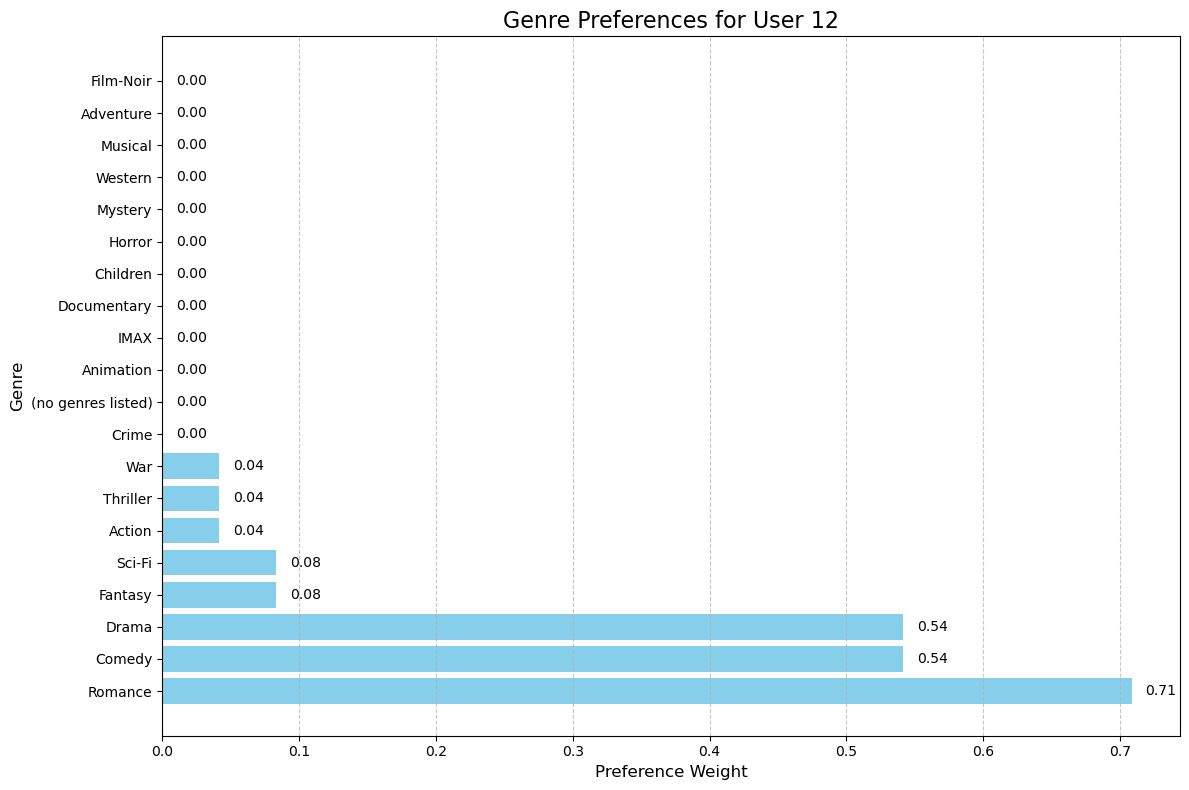

Movies rated by User 12:
+---------------------------------+------------------------------+------+
|title                            |genres                        |rating|
+---------------------------------+------------------------------+------+
|First Knight (1995)              |Action|Drama|Romance          |5.0   |
|Circle of Friends (1995)         |Drama|Romance                 |5.0   |
|Junior (1994)                    |Comedy|Sci-Fi                 |5.0   |
|Emma (1996)                      |Comedy|Drama|Romance          |5.0   |
|Shine (1996)                     |Drama|Romance                 |5.0   |
|Titanic (1997)                   |Drama|Romance                 |5.0   |
|'burbs, The (1989)               |Comedy                        |5.0   |
|She's All That (1999)            |Comedy|Romance                |5.0   |
|10 Things I Hate About You (1999)|Comedy|Romance                |5.0   |
|Never Been Kissed (1999)         |Comedy|Romance                |5.0   |
|Ghostbusters

In [27]:
import pandas as pd
import numpy as np

# Creating a new visualization of the user profile based on genres
import matplotlib.pyplot as plt

# Convert user profile to a pandas Series for easier visualization
user_profile_series = pd.Series({genre: user_profile[genre] for genre in all_genres})

# Sort genres by preference weight
sorted_profile = user_profile_series.sort_values(ascending=False)

# Create a horizontal bar chart
plt.figure(figsize=(12, 8))
bars = plt.barh(sorted_profile.index, sorted_profile.values, color='skyblue')

# Add values on the bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{width:.2f}', va='center')

plt.title(f'Genre Preferences for User {user_id}', fontsize=16)
plt.xlabel('Preference Weight', fontsize=12)
plt.ylabel('Genre', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Print movies user has rated along with genres
print(f"Movies rated by User {user_id}:")
liked_movies.join(movies, on="movieId") \
    .select("title", "genres", "rating") \
    .orderBy("rating", ascending=False) \
    .show(truncate=False)

In [28]:
import numpy as np

user_profile_vector = np.array([user_profile[genre] for genre in all_genres])

In [29]:
print(user_profile_vector)

[0.         0.         0.         0.08333333 0.         0.
 0.54166667 0.70833333 0.         0.04166667 0.         0.
 0.08333333 0.54166667 0.         0.         0.04166667 0.
 0.04166667 0.        ]


In [30]:
# Films déjà vus (movieId)
seen_movies = liked_movies.select('movieId').distinct()

# Films non vus par l'utilisateur
unseen_movies_profiles = movies_profiles.join(seen_movies, on='movieId', how='left_anti')

#### Similarité cosinus

In [31]:
from pyspark.sql import functions as F
import numpy as np

def recommend_by_genre_similarity(movies_profiles, user_id, ratings, all_genres, n=10):
    """
    Recommends movies to a user based on genre similarity.
    
    Parameters:
    -----------
    movies_profiles : DataFrame
        DataFrame containing movie profiles with genre information
    user_id : int
        ID of the user to generate recommendations for
    ratings : DataFrame
        DataFrame containing user ratings
    all_genres : list
        List of all available genres
    n : int, optional
        Number of recommendations to return (default 10)
        
    Returns:
    --------
    DataFrame
        Top n movie recommendations sorted by similarity
    """
    # Get movies liked by the user (rated 4 or higher)
    liked_movies = ratings.filter((F.col("userId") == user_id) & (F.col("rating") >= 4))
    
    # Join with movie profiles
    liked_movies_profiles = liked_movies.join(movies_profiles, "movieId", "inner")
    
    # Calculate user profile based on genre preferences
    user_profile = liked_movies_profiles.agg(
        *[F.mean(genre).alias(genre) for genre in all_genres]
    ).collect()[0]
    
    # Convert user profile to vector and calculate its norm
    user_profile_vector = np.array([user_profile[genre] for genre in all_genres])
    user_norm = float(np.linalg.norm(user_profile_vector))
    
    # Get movies not seen by the user
    seen_movies = liked_movies.select('movieId').distinct()
    unseen_movies_profiles = movies_profiles.join(seen_movies, on='movieId', how='left_anti')
    
    # Calculate cosine similarity
    # 1. Compute dot product between user profile and movie genres
    exprs = [
        F.lit(user_profile_vector[i]) * F.col(genre)
        for i, genre in enumerate(all_genres)
    ]
    dot_prod = sum(exprs)
    
    # 2. Calculate movie profile norm
    film_norm = F.sqrt(sum(F.col(genre) * F.col(genre) for genre in all_genres))
    
    # 3. Calculate cosine similarity
    df = unseen_movies_profiles.withColumn(
        'similarity',
        F.when((film_norm != 0) & F.lit(user_norm != 0),
               dot_prod / (film_norm * F.lit(user_norm))).otherwise(0)
    )
    
    # Sort by similarity and return top n recommendations
    return df.orderBy(F.col('similarity').desc()).limit(n)

# Example usage
top_recos = recommend_by_genre_similarity(movies_profiles, user_id, ratings, all_genres, 10)
top_recos.select('movieId', 'title', 'similarity').show(10)


+-------+--------------------+------------------+
|movieId|               title|        similarity|
+-------+--------------------+------------------+
|     94|Beautiful Girls (...|0.9828731898973629|
|    372|Reality Bites (1994)|0.9828731898973629|
|    195|Something to Talk...|0.9828731898973629|
|      4|Waiting to Exhale...|0.9828731898973629|
|    224|Don Juan DeMarco ...|0.9828731898973629|
|     58|Postman, The (Pos...|0.9828731898973629|
|    232|Eat Drink Man Wom...|0.9828731898973629|
|    351|Corrina, Corrina ...|0.9828731898973629|
|    361|It Could Happen t...|0.9828731898973629|
|     52|Mighty Aphrodite ...|0.9828731898973629|
+-------+--------------------+------------------+



In [32]:
top_10 = top_recos.select('movieId', 'title', 'similarity').limit(10)
top_10.show(truncate=False)


+-------+-------------------------------------------+------------------+
|movieId|title                                      |similarity        |
+-------+-------------------------------------------+------------------+
|94     |Beautiful Girls (1996)                     |0.9828731898973629|
|372    |Reality Bites (1994)                       |0.9828731898973629|
|195    |Something to Talk About (1995)             |0.9828731898973629|
|4      |Waiting to Exhale (1995)                   |0.9828731898973629|
|224    |Don Juan DeMarco (1995)                    |0.9828731898973629|
|58     |Postman, The (Postino, Il) (1994)          |0.9828731898973629|
|232    |Eat Drink Man Woman (Yin shi nan nu) (1994)|0.9828731898973629|
|351    |Corrina, Corrina (1994)                    |0.9828731898973629|
|361    |It Could Happen to You (1994)              |0.9828731898973629|
|52     |Mighty Aphrodite (1995)                    |0.9828731898973629|
+-------+------------------------------------------

In [33]:
cols_to_show = ['title'] + all_genres
top_10_genres = top_recos.select(*cols_to_show).limit(10)
top_10_genres.show(truncate=False)


+-------------------------------------------+-----+------+---------+------+-------+-------+------+-------+-------+---+-----------+--------+-------+-----+----+---------+--------+------------------+------+---------+
|title                                      |Crime|Horror|Adventure|Sci-Fi|Musical|Western|Comedy|Romance|Mystery|War|Documentary|Children|Fantasy|Drama|IMAX|Animation|Thriller|(no genres listed)|Action|Film-Noir|
+-------------------------------------------+-----+------+---------+------+-------+-------+------+-------+-------+---+-----------+--------+-------+-----+----+---------+--------+------------------+------+---------+
|Beautiful Girls (1996)                     |0    |0     |0        |0     |0      |0      |1     |1      |0      |0  |0          |0       |0      |1    |0   |0        |0       |0                 |0     |0        |
|Reality Bites (1994)                       |0    |0     |0        |0     |0      |0      |1     |1      |0      |0  |0          |0       |0    

In [34]:
for genre in all_genres:
    print(f"{genre:15s} : {user_profile[genre]:.2f}")


Crime           : 0.00
Horror          : 0.00
Adventure       : 0.00
Sci-Fi          : 0.08
Musical         : 0.00
Western         : 0.00
Comedy          : 0.54
Romance         : 0.71
Mystery         : 0.00
War             : 0.04
Documentary     : 0.00
Children        : 0.00
Fantasy         : 0.08
Drama           : 0.54
IMAX            : 0.00
Animation       : 0.00
Thriller        : 0.04
(no genres listed) : 0.00
Action          : 0.04
Film-Noir       : 0.00


#### Recommandations pour quelques utilisateurs

In [ ]:
# list of users to analyze
user_ids = [10, 12, 15]

for uid in user_ids:
    print(f"\n=== Utilisateur {uid} ===")
    print("Films notés :")
    ratings.filter((col("userId") == uid) & (col("rating") >= 4)) \
        .join(movies, on="movieId", how="left") \
        .select("title", "genres", "rating") \
        .orderBy(col("rating").desc()) \
        .show(truncate=False)
    
    # Use the function we defined earlier to get recommendations
    recommendations = recommend_by_genre_similarity(
        movies_profiles, 
        uid, 
        ratings, 
        all_genres, 
        n=5
    )
    
    print("Top 5 recommandations (cosine similarity) :")
    recommendations.select("title", "genres", "similarity") \
        .show(truncate=False)



=== Utilisateur 10 ===
Films notés :
+-------------------------------+---------------------------------------------------+------+
|title                          |genres                                             |rating|
+-------------------------------+---------------------------------------------------+------+
|Troy (2004)                    |Action|Adventure|Drama|War                         |5.0   |
|Notebook, The (2004)           |Drama|Romance                                      |5.0   |
|First Daughter (2004)          |Comedy|Romance                                     |5.0   |
|Batman Begins (2005)           |Action|Crime|IMAX                                  |5.0   |
|Casino Royale (2006)           |Action|Adventure|Thriller                          |5.0   |
|Holiday, The (2006)            |Comedy|Romance                                     |5.0   |
|Education, An (2009)           |Drama|Romance                                      |5.0   |
|Despicable Me (2010)           

#### Calcul de métriques

In [36]:
from pyspark.sql.functions import col

def precision_recall_at_k(user_id, top_k, ratings, recs_with_titles):
    """
    Calcule la précision et le rappel @k pour un utilisateur donné.
    """
    # Films likés (rating >= 4)
    liked = ratings.filter((col("userId") == user_id) & (col("rating") >= 4)).select("movieId").distinct()
    n_liked = liked.count()
    if n_liked == 0:
        return 0.0, 0.0

    # Top-k recommandations
    topk_recs = recs_with_titles.filter(col("userId") == user_id).orderBy(col("score").desc()).limit(top_k).select("movieId")
    n_recs = topk_recs.count()
    if n_recs == 0:
        return 0.0, 0.0

    # True positives
    true_positives = topk_recs.join(liked, on="movieId", how="inner").count()

    precision = true_positives / n_recs
    recall = true_positives / n_liked
    return precision, recall

# Exemple d'utilisation pour l'utilisateur 10
prec_10, recall_10 = precision_recall_at_k(10, TOP_K, ratings, recs_with_titles)
print(f"Précision@{TOP_K} utilisateur 10 : {prec_10:.4f}")
print(f"Recall@{TOP_K} utilisateur 10 : {recall_10:.4f}")

Précision@5 utilisateur 10 : 0.2000
Recall@5 utilisateur 10 : 0.0200


In [37]:
# Évaluation du modèle pour plusieurs utilisateurs avec plusieurs métriques

def evaluate_model_for_users(user_ids, top_k, ratings, recs_with_titles):
    """
    Calcule précision@k, rappel@k et couverture pour une liste d'utilisateurs.
    """
    precisions = []
    recalls = []
    n_users_with_liked = 0
    n_users_with_recs = 0
    all_recommended = set()
    all_liked = set()
    
    for uid in user_ids:
        liked = ratings.filter((col("userId") == uid) & (col("rating") >= 4)).select("movieId").distinct()
        n_liked = liked.count()
        if n_liked == 0:
            continue
        n_users_with_liked += 1
        topk_recs = recs_with_titles.filter(col("userId") == uid).orderBy(col("score").desc()).limit(top_k).select("movieId")
        n_recs = topk_recs.count()
        if n_recs == 0:
            continue
        n_users_with_recs += 1
        true_positives = topk_recs.join(liked, on="movieId", how="inner").count()
        precisions.append(true_positives / n_recs)
        recalls.append(true_positives / n_liked)
        all_recommended.update([row.movieId for row in topk_recs.collect()])
        all_liked.update([row.movieId for row in liked.collect()])
    
    avg_precision = sum(precisions) / len(precisions) if precisions else 0.0
    avg_recall = sum(recalls) / len(recalls) if recalls else 0.0
    coverage = len(all_recommended) / recs_with_titles.select("movieId").distinct().count() if all_recommended else 0.0
    user_coverage = n_users_with_recs / len(user_ids) if user_ids else 0.0
    
    print(f"Nombre d'utilisateurs évalués : {len(user_ids)}")
    print(f"Utilisateurs avec films likés : {n_users_with_liked}")
    print(f"Utilisateurs avec recommandations : {n_users_with_recs}")
    print(f"Précision@{top_k} moyenne : {avg_precision:.4f}")
    print(f"Recall@{top_k} moyen : {avg_recall:.4f}")
    print(f"Couverture des recommandations : {coverage:.4f}")
    print(f"Couverture utilisateur : {user_coverage:.4f}")

# Exemple d'utilisation
evaluate_model_for_users(user_ids, TOP_K, ratings, recs_with_titles)

Nombre d'utilisateurs évalués : 3
Utilisateurs avec films likés : 3
Utilisateurs avec recommandations : 3
Précision@5 moyenne : 0.0667
Recall@5 moyen : 0.0067
Couverture des recommandations : 0.0932
Couverture utilisateur : 1.0000
